# Chapter 3. Classification

## Notes and code-along

In [1]:
from sklearn.datasets import fetch_mldata

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
from six.moves import urllib
from sklearn.datasets import fetch_mldata
try:
    mnist = fetch_mldata('MNIST original')
except ConnectionResetError:
    print("Could not download MNIST data from mldata.org, trying alternative...")

    # Alternative method to load MNIST, if mldata.org is down
    from scipy.io import loadmat
    mnist_alternative_url = "https://github.com/amplab/datascience-sp14/raw/master/lab7/mldata/mnist-original.mat"
    mnist_path = "./mnist-original.mat"
    response = urllib.request.urlopen(mnist_alternative_url)
    with open(mnist_path, "wb") as f:
        content = response.read()
        f.write(content)
    mnist_raw = loadmat(mnist_path)
    mnist = {
        "data": mnist_raw["data"].T,
        "target": mnist_raw["label"][0],
        "COL_NAMES": ["label", "data"],
        "DESCR": "mldata.org dataset: mnist-original",
    }
    print("Success!")

Could not download MNIST data from mldata.org, trying alternative...
Success!


In [4]:
mnist

{'COL_NAMES': ['label', 'data'],
 'DESCR': 'mldata.org dataset: mnist-original',
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'target': array([0., 0., 0., ..., 9., 9., 9.])}

In [5]:
X, y = mnist['data'], mnist['target']

In [6]:
X.shape

(70000, 784)

In [7]:
y.shape

(70000,)

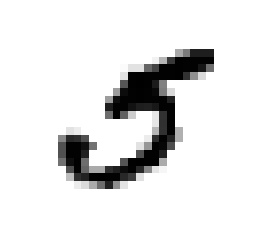

In [8]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

some_digit = X[36000]
some_digit_image = some_digit.reshape(28,28)

plt.imshow(some_digit_image, cmap = matplotlib.cm.binary, interpolation='nearest')
plt.axis('off')
plt.show()

In [9]:
y[36000]

5.0

In [10]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [11]:
import numpy as np

shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

### Training a Binary Classifier

In [12]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [13]:
# SGD
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [14]:
sgd_clf.predict([some_digit])

array([ True])

In [15]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.96125, 0.96435, 0.9715 ])

In [16]:
# The never 5 Clf
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [17]:
never_5_clf = Never5Classifier()

In [18]:
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.90825, 0.91135, 0.90935])

In [19]:
# confusion matrix
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [20]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53994,   585],
       [ 1473,  3948]])

In [21]:
from sklearn.metrics import precision_score, recall_score

In [22]:
precision_score(y_train_5, y_train_pred)

0.870946393117141

In [23]:
recall_score(y_train_5, y_train_pred)

0.728278915329275

In [24]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7932489451476793

In [25]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([118681.14413775])

In [26]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [27]:
threshold = 200000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [28]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')

In [29]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

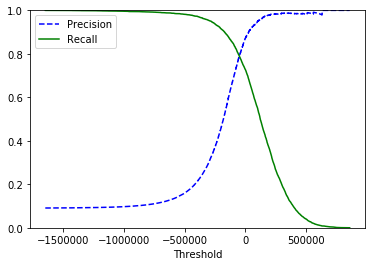

In [30]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.ylim([0, 1])

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [31]:
y_train_pred_90 = (y_scores > 70000)

In [32]:
precision_score(y_train_5, y_train_pred_90)

0.9309462915601023

In [33]:
recall_score(y_train_5, y_train_pred_90)

0.60431654676259

In [34]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

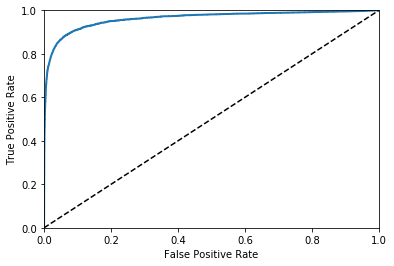

In [35]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
plot_roc_curve(fpr, tpr)
plt.show()

In [36]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9622791431096229

In [37]:
# RF
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

In [38]:
y_scores_forest = y_probas_forest[:, 1]

In [39]:
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

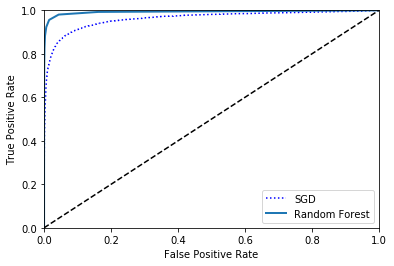

In [40]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="bottom right")
plt.show()

In [41]:
roc_auc_score(y_train_5, y_scores_forest)

0.9930667223068008

In [42]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([5.])

In [43]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[-143139.22495876, -452727.95845768, -386601.86124348,
        -187036.4816829 , -356146.80588762,  118681.14413775,
        -688007.76173726, -255909.4234716 , -646974.04477931,
        -526123.77524407]])

In [44]:
np.argmax(some_digit_scores)

5

In [45]:
sgd_clf.classes_

array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.])

In [46]:
# creating one_vs_one classifier
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

array([5.])

In [47]:
len(ovo_clf.estimators_)

45

In [48]:
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array([5.])

In [49]:
forest_clf.predict_proba([some_digit])

array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]])

In [50]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.86987602, 0.85864293, 0.87128069])

In [51]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring='accuracy')

array([0.91061788, 0.90949547, 0.91188678])

### Error Analysis

In [52]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5740,    2,   22,    9,   12,   46,   41,    9,   39,    3],
       [   1, 6491,   45,   27,    5,   46,    7,    9,   99,   12],
       [  56,   31, 5374,   74,   88,   27,   90,   56,  147,   15],
       [  48,   38,  147, 5325,    2,  247,   40,   57,  133,   94],
       [  21,   22,   36,   10, 5349,   11,   53,   29,   82,  229],
       [  72,   41,   43,  180,   78, 4601,  102,   30,  175,   99],
       [  33,   23,   48,    2,   41,   79, 5645,    3,   44,    0],
       [  24,   23,   68,   33,   57,   11,    7, 5804,   15,  223],
       [  54,  144,   73,  160,   14,  156,   55,   25, 5025,  145],
       [  51,   26,   27,   91,  156,   35,    2,  198,   77, 5286]])

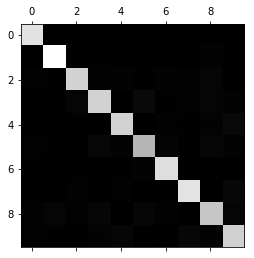

In [53]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

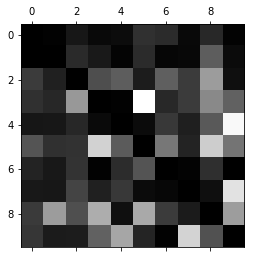

In [54]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

### Multilabel CLF

In [56]:
from sklearn.neighbors import KNeighborsClassifier
y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

In [57]:
knn_clf.predict([some_digit])

array([[False,  True]])

In [58]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_train, cv=3, n_jobs=-1)
f1_score(y_train, y_train_knn_pred, average="macro")

0.9685530593007641

### Multioutput CLF

In [65]:
noise_train = np.random.randint(0, 100, (len(X_train), 784))
noise_test = np.random.randint(0, 100, (len(X_test), 784))
X_train_mod = X_train + noise_train
X_test_mod = X_test + noise_test
y_train_mod = X_train
y_test_mod = X_test

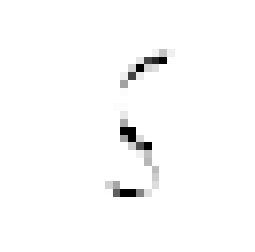

In [68]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[5474]])
clean_digit_image = clean_digit.reshape(28,28)
plt.imshow(clean_digit_image, cmap = matplotlib.cm.binary, interpolation='nearest')
plt.axis('off')
plt.show()

## Exercises

### 1. Try to build a classifier for the MNIST dataset that achieves over 97% accuracy on the test set.  
Hint: the KNeighborsClassifier works quite well for this task; you just need to find good hyperparameter values (try a grid search on the weights and n_neighbors hyperparameters).

In [ ]:
from sklearn.model_selection import GridSearchCV
# as the hint suggests - KNN it is.
knn = KNeighborsClassifier()
param_grid = [{
    'n_neighbors':range(3, 10),
    'weights': ['uniform', 'distance']
}]

grid_search_knn = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy', verbose=3, n_jobs=-1)
grid_search_knn.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


In [ ]:
grid_search_knn.best_score_

In [ ]:
y_pred = grid_search_knn.predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, y_pred)

### 2. Write a function that can shift an MNIST image in any direction (left, right, up, or down) by one pixel. 
Then, for each image in the training set, create four shifted copies (one per direction) and
add them to the training set. Finally, train your best model on this expanded training set and
measure its accuracy on the test set. You should observe that your model performs even better
now! This technique of artificially growing the training set is called data augmentation or
training set expansion.

In [ ]:
# cheating here - looking at the notebooks
from scipy.ndimage.interpolation import shif

In [ ]:
def shift_image(image, dx, dy):
    image = image.reshape((28, 28))
    shifted_image = shift(image, [dy, dx], cval=0, mode="constant")
    return shifted_image.reshape([-1])

In [ ]:
image = X_train[1000]
shifted_image_down = shift_image(image, 0, 5)
shifted_image_left = shift_image(image, -5, 0)

plt.figure(figsize=(12,3))
plt.subplot(131)
plt.title("Original", fontsize=14)
plt.imshow(image.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.subplot(132)
plt.title("Shifted down", fontsize=14)
plt.imshow(shifted_image_down.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.subplot(133)
plt.title("Shifted left", fontsize=14)
plt.imshow(shifted_image_left.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.show()

In [ ]:
X_train_augmented = [image for image in X_train]
y_train_augmented = [label for label in y_train]

for dx, dy in ((1, 0), (-1, 0), (0, 1), (0, -1)):
    for image, label in zip(X_train, y_train):
        X_train_augmented.append(shift_image(image, dx, dy))
        y_train_augmented.append(label)

X_train_augmented = np.array(X_train_augmented)
y_train_augmented = np.array(y_train_augmented)

In [ ]:
shuffle_idx = np.random.permutation(len(X_train_augmented))
X_train_augmented = X_train_augmented[shuffle_idx]
y_train_augmented = y_train_augmented[shuffle_idx]

In [ ]:
knn_clf = KNeighborsClassifier(**grid_search.best_params_)
knn_clf.fit(X_train_augmented, y_train_augmented)

In [ ]:
y_pred = knn_clf.predict(X_test)
accuracy_score(y_test, y_pred)

### 3. Tackle the Titanic dataset. A great place to start is on Kaggle.
Already done [here](https://github.com/gsam1/dsml-projects/blob/master/5_Playground/Titanic_Machine_Learning_from_Disaster.ipynb).

### 4. Build a spam classifier (a more challenging exercise).